In [1]:
%%bash
# download once
# python -m spacy download en_core_web_lg

In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.decomposition import (
    LatentDirichletAllocation, 
    NMF,
)
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    cohen_kappa_score,
    ConfusionMatrixDisplay,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
)
from sklearn.model_selection import (
    StratifiedKFold, 
    train_test_split,
)
from load_scrape_data import get_clean_data_df
from constants import (
    DESC_K,   
    ESRB_K,
    TITLE_K,
)
from nlp_utils import (
    evaluate_model,    
    nlp,
    normalize_text,
    NORMED_DESC_K,
    topic_model_breakdown,
    topic_model_breakdown_per_esrb,
)

In [3]:
df = get_clean_data_df()

In [4]:
# filter for has description & ESRB
has_desc_mask = pd.notna(df[DESC_K])
has_esrb_mask = pd.notna(df[ESRB_K])
has_desc_esrb_mask = has_desc_mask & has_esrb_mask
df.loc[has_desc_esrb_mask, ESRB_K].value_counts()

esrb
6+     10971
13+     7078
17+     3423
10+     3284
?         59
3+        56
18+       45
Name: count, dtype: int64

In [5]:
# drop low count ESRBs
is_low_count_esrb = df[ESRB_K].isin({'?', '3+', '18+'})
data_mask = has_desc_esrb_mask & ~is_low_count_esrb
data_df = df.loc[data_mask]
data_df[ESRB_K].value_counts()

esrb
6+     10971
13+     7078
17+     3423
10+     3284
Name: count, dtype: int64

In [6]:
# normalize descriptions
normed_descs = data_df[DESC_K].apply(normalize_text)
data_df[NORMED_DESC_K] = normed_descs  # TODO SettingWithCopyWarning

/tmp/ipykernel_60389/52290168.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[NORMED_DESC_K] = normed_descs  # TODO SettingWithCopyWarning


#### topic modeling

In [7]:
corpus=data_df[NORMED_DESC_K]
docs=data_df[TITLE_K]
min_df = 10  # min doc freq; words in few docs are bad discriminators
n_grams = (1,3)  # uni thru tri-grams
num_topics = 15
top_n = 15  # words | docs per topic 

# vectorizers = docs of words -> matrix
doc_term_vectorizer_tf = CountVectorizer(
    min_df=min_df,
    ngram_range=n_grams,
)
doc_term_vectorizer_tfidf = TfidfVectorizer(
    min_df=min_df,  
    ngram_range=n_grams,
)

# models
nmf_model = NMF(
    init='nndsvda',   # default for small num_topics, but explicit is best
    n_components=num_topics,
    random_state=1,
)
lda_model = LatentDirichletAllocation(
    n_components=num_topics,
    learning_method='online',
    random_state=1,
)

# fit models on matrices
nmf_topics_df = topic_model_breakdown(corpus, doc_term_vectorizer_tfidf, docs, nmf_model, top_n)
nmf_esrb_grouped_topics_df = topic_model_breakdown_per_esrb(data_df, doc_term_vectorizer_tfidf, nmf_model, top_n)

lda_topics_df = topic_model_breakdown(corpus, doc_term_vectorizer_tf, docs, lda_model, top_n)
lda_esrb_grouped_topics_df = topic_model_breakdown_per_esrb(data_df, doc_term_vectorizer_tf, lda_model, top_n)

/home/aren/.cache/pypoetry/virtualenvs/ar15-scrape-Pe3KTmo1-py3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/aren/.cache/pypoetry/virtualenvs/ar15-scrape-Pe3KTmo1-py3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [8]:
# nmf_esrb_grouped_topics_df.to_csv('nmf_esrb_grouped_topics.tsv', sep='\t')
# nmf_topics_df.to_csv('nmf_topics.tsv', sep='\t')
# lda_esrb_grouped_topics_df.to_csv('lda_esrb_grouped_topics.tsv', sep='\t')
# lda_topics_df.to_csv('lda_topics.tsv', sep='\t')

#### cross validation

In [9]:
# stratified test set withheld
# note: using train-validation-test syntax vs sklearn's train-test-validation

corpus = data_df[NORMED_DESC_K]
n_splits = 10
xs = doc_term_vectorizer_tfidf.fit_transform(corpus)
ys = data_df[ESRB_K]

train_val_xs, test_xs, train_val_ys, test_ys = train_test_split(
    xs,
    ys,
    random_state=1,
    stratify=ys,
    test_size=0.1,
)

10it [00:49,  4.92s/it]


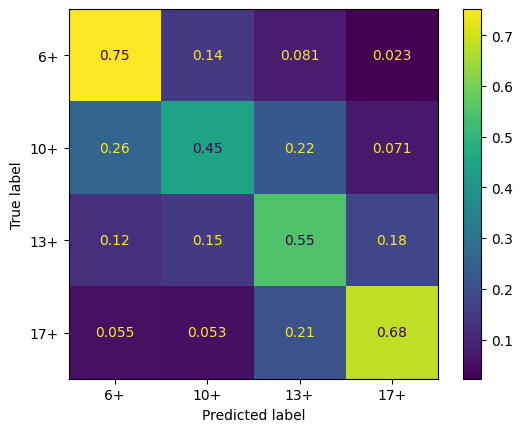

In [10]:
# train-validate tuning
labels = ['6+', '10+', '13+', '17+']  # sorted ESRBs

skf = StratifiedKFold(
    n_splits=n_splits, 
    random_state=1,
    shuffle=True,
)
train_val_classifier = LogisticRegression(
    class_weight='balanced',
    max_iter=int(1E3),
    random_state=1,
)
# k fold fit & predict w/ train-validation set
train_val_truths, train_val_preds = evaluate_model(
    skf,
    train_val_classifier,
    train_val_xs,
    train_val_ys,
)
# micro averaged confusion matrix
ConfusionMatrixDisplay.from_predictions(
    train_val_truths,
    train_val_preds,
    labels=labels,
    # labels=int_labels,
    normalize='true',
)

In [11]:
# class proportions for contrast
data_df[ESRB_K].value_counts(normalize=True)

esrb
6+     0.443165
13+    0.285910
17+    0.138270
10+    0.132655
Name: proportion, dtype: float64

#### test set performance

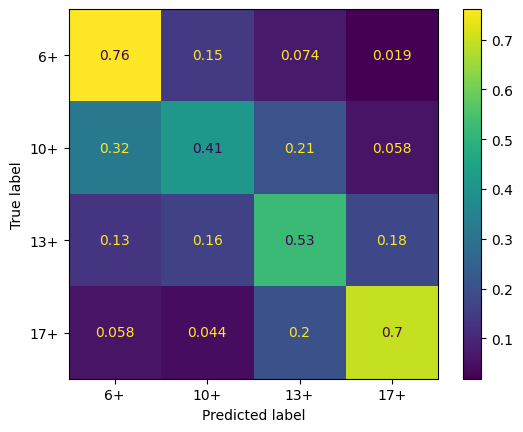

In [12]:
test_classifier = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=1,
)
test_classifier.fit(train_val_xs, train_val_ys)
test_preds = test_classifier.predict(test_xs)
ConfusionMatrixDisplay.from_predictions(
    test_ys,
    test_preds,
    labels=labels,
    normalize='true',
)

In [13]:
# scalar metrics of test set performance
f1 = f1_score(
    test_ys,
    test_preds,
    average='weighted',
)

map = {'6+': 0, '10+': 1, '13+': 2, '17+': 3,}
proba_preds = test_classifier.predict_proba(test_xs)
roc_auc = roc_auc_score(
    test_ys.map(map),  # labels must be ints
    proba_preds,
    multi_class='ovr',  # one vs rest
)

cohen_kappa = cohen_kappa_score(test_ys, test_preds)

matthews = matthews_corrcoef(test_ys, test_preds)

print(f'f1: {f1}')
print(f'roc_auc :{roc_auc}')
print(f'cohen_kappa: {cohen_kappa}')
print(f'matthews: {matthews}')

f1: 0.6436400941044158
roc_auc :0.4553295353491597
cohen_kappa: 0.4819049453784048
matthews: 0.4835907124156217


#### What about word2vec instead of TF-IDF?

In [14]:
doc_vecs = data_df[NORMED_DESC_K].apply(lambda x: nlp(x).vector)
xs = np.array(list(doc_vecs))
# normed_xs = np.interp(xs, (xs.min(), xs.max()), (-1, 1))  # normalize from -1 to 1

In [15]:
train_val_xs, test_xs, train_val_ys, test_ys = train_test_split(
    xs,
    # normed_xs,
    ys,
    random_state=1,
    stratify=ys,
    test_size=0.1,
)

10it [02:55, 17.57s/it]


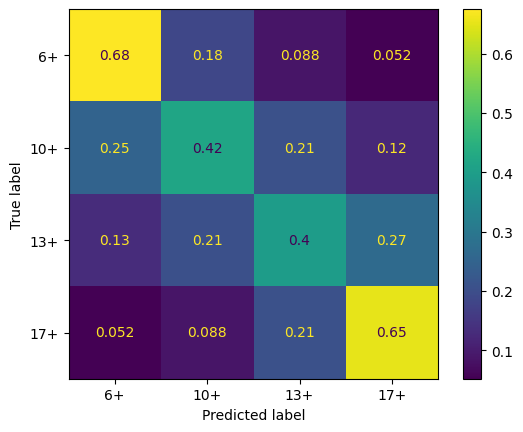

In [16]:
train_val_classifier = LogisticRegression(
    class_weight='balanced',
    max_iter=int(1E4),
    random_state=1,
)
train_val_truths, train_val_preds = evaluate_model(
    skf,
    train_val_classifier,
    train_val_xs,
    train_val_ys,
)

# micro averaged confusion matrix
ConfusionMatrixDisplay.from_predictions(
    train_val_truths,
    train_val_preds,
    labels=labels,
    normalize='true',
)

#### less successful model graveyard

In [17]:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neural_network

# from sklearn.tree import DecisionTreeClassifier
# classifier = DecisionTreeClassifier(
#     class_weight='balanced',
#     # min_samples_split = 10,
#     random_state=1,
# )

# from sklearn.svm import LinearSVC
# classifier = LinearSVC(
#     class_weight='balanced',
#     dual='auto',
# )

# from sklearn.linear_model import RidgeClassifier
# RidgeClassifier(
#     class_weight='balanced',
#     random_state=1,
# )

# from sklearn.naive_bayes import ComplementNB
# classifier = ComplementNB()

# from sklearn.neighbors import KNeighborsClassifier
# classifier = KNeighborsClassifier(
#     n_neighbors=5,
#     weights='distance',
# )

# from sklearn.tree import DecisionTreeClassifier
# classifier = DecisionTreeClassifier(
#     class_weight='balanced',
#     # min_samples_split = 10,
#     random_state=1,
# )